# CSE527 Homework 3
**Due date: 23:59 on Oct 22, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Using SIFT in OpenCV 3.x.x in Colab
---
The default version of OpenCV in Colab is 3.4.3. If we use SIFT method directly, typically we will get this error message:

```
error: OpenCV(3.4.3) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'

```

One simple way to use the OpenCV in-built function `SIFT` in Colab is to switch the version to the one from 'contrib'. Below is an example of switching OpenCV version:

1. Run the following command in one section in Colab, which has already been included in this assignment:
```
pip install opencv-contrib-python==3.4.2.16
```
2. Restart runtime by
```
Runtime -> Restart Runtime
```

Then you should be able to use use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object, whose functions are listed at http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html

## Some Resources
---
In addition to the tutorial document, the following resources can definitely help you in this homework:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
- http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
- http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=sift#cv2.SIFT
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html


## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 16 categories by training and testing on the 16
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---

The starter code trains on 150 and tests on 50 images from each category (i.e. 2400
training examples total and 800 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.

Save the [dataset(click me)](https://drive.google.com/drive/folders/1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M?usp=sharing) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.25% accuracy
(1 out of 16 guesses is correct).

In [0]:
pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 30.6MB 1.7MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
import zipfile
import torch
import torchvision
import gc
import pickle
from sklearn import svm
from skimage import color
from skimage import io
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn import svm, multiclass

print(cv2.__version__) # verify OpenCV version

3.4.2


In [1]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw3' is just an example, 
#   change it to your specific homework directory.
# cd '/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw3'
# cd '/-------/-------/-------/'
# cd gdrive/My\ Drive/
# cd CV/CSE527-HW3-Fall19/
cd gdrive/My Drive/CV/CSE527-HW3-Fall19

/content/gdrive/My Drive/CV/CSE527-HW3-Fall19



## Data Preparation

In [0]:
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples_per_class = 150
n_test_samples_per_class = 50

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('./data/train/')
train_data, train_label = load_dataset('./data/train/', n_train_samples_per_class)
n_train = len(train_label)
print("n_train: %s" % n_train)

# load testing dataset
# test_data, test_label = load_dataset('./data/test/')
test_data, test_label = load_dataset('./data/test/', n_test_samples_per_class)
n_test = len(test_label)
print("n_test: %s" % n_test)

class_names: {0: 'Forest', 1: 'Industrial', 2: 'Flower', 3: 'Coast', 4: 'InsideCity', 5: 'Office', 6: 'Bedroom', 7: 'Highway', 8: 'Street', 9: 'TallBuilding', 10: 'LivingRoom', 11: 'Suburb', 12: 'OpenCountry', 13: 'Mountain', 14: 'Kitchen', 15: 'Store'} 


In [0]:
# As loading the data from the source for the first time is time consuming, so you can pkl or save the data in a compact way such that subsequent data loading is faster
# Save intermediate image data into disk
file = open('train.pkl','wb')
pickle.dump(train_data, file)
pickle.dump(train_label, file)
file.close()

file = open('test.pkl','wb')
pickle.dump(test_data, file)
pickle.dump(test_label, file)
file.close()

In [0]:
# Load intermediate image data from disk
file = open('train.pkl', 'rb')
train_data = pickle.load(file)
train_label = pickle.load(file)
file.close()

file = open('test.pkl', 'rb')
test_data = pickle.load(file)
test_label = pickle.load(file)
file.close()

print(len(train_data), len(train_label)) # Verify number of training samples
print(len(test_data), len(test_label))   # Verify number of testing samples

2400 2400
400 400


In [0]:
# plt.imshow(train_data[1], cmap='gray') # Verify image
img_new_size = (240, 240)

train_data = list(map(lambda x: cv2.resize(x, img_new_size), train_data))
train_data = np.stack(train_data)
train_label = np.array(train_label)

test_data = list(map(lambda x: cv2.resize(x, img_new_size), test_data))
test_data = np.stack(test_data)
test_label = np.array(test_label)

uint8


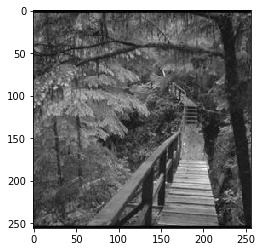

In [0]:
# Verify image
plt.imshow(train_data[1], cmap='gray')
print(train_data[0].dtype)

In [0]:
n_train = len(train_label)
n_test = len(test_label)

# feature extraction
def extract_feat(raw_data):
    print(len(raw_data))
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in np.arange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
    print("feat",len(feat))
    
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(16) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in np.arange(n_test):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(n_test)

print("The accuracy of my dummy model is {:.2f}%".format(accuracy*100))
print(train_data.shape)
print(train_feat.shape)

## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [0]:
# Write your codes here

tiny_img_size = (16, 16)  # dimentions of time images (16x16)

def tiny_normalized_img(image):           # function to resize and normalize the images
  img = cv2.resize(image, tiny_img_size)  # standard normalization
  normalized = (img-img.mean())/img.std()
  return normalized.flatten()             # Image flatten for Training

train_data1 = list(map(tiny_normalized_img, train_data))  # maping function to convert every train image
train_data1 = np.stack(train_data1)
train_label = np.array(train_label)

test_data1 = list(map(tiny_normalized_img, test_data))    # maping function to convert every test image
test_data1 = np.stack(test_data1)
test_label = np.array(test_label)


# train Kneighbourclassifier
t1 = time.time()                   # Making note of current time
model1 = KNeighborsClassifier(n_neighbors=16, algorithm='kd_tree').fit(train_data1, train_label)
accuracy1 = model1.score(test_data1, test_label)
time1 = time.time() - t1           # Subtracting the current time from initial timestamp

print("The accuracy of KNeighboursClassifier with Tiny-images is {:.2f}% with time taken = {}sec".format(accuracy1*100, time1))
pred1 = model1.predict(test_data1)
label1 = test_label

The accuracy of KNeighboursClassifier with Tiny-images is 22.75% with time taken = 0.5134134292602539sec


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

After you obtain the Bag of SIFT feature representation of the images, you have to
train a KNN classifier in the Bag of SIFT feature space and report your test set accuracy and time consumption. 

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).
- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

In [0]:
# Write your codes here

# Variables
train_len = len(train_data)          # Length of train images
test_len = len(test_data)            # Length of test images
train_sifts = list()                 # List of SIFT features of train images (Grouped)
test_sifts = list()                  # List of SIFT features of test images (Grouped)
step_size = 10                       # Sampling size for dense features
vocab = np.zeros((0, 128))           # Variabe for storing individual SIFT features as vocabulary
train_features = np.zeros((train_len, 50))  # Variable for storing Bag of words for train data
test_features = np.zeros((test_len, 50))    # Variable for storing Bag of words for test data

Create Train Vocabulary with SIFT Features
for i in range(train_len):
  sift = cv2.xfeatures2d.SIFT_create()
  dense_Kpgrid = [cv2.KeyPoint(x, y, step_size) for x in range(0, train_data[i].shape[0], step_size) for y in range(0, train_data[i].shape[1], step_size)]
  k, des = sift.compute(train_data[i], dense_Kpgrid)
  train_sifts.append(des)
  vocab = np.vstack((vocab, des))

train_sifts = np.array(train_sifts)

# Create bag of words
gc.collect()
kmeans = KMeans(n_clusters=50).fit(vocab)

# Extract Test-data's SIFT Features
for i in range(test_len):
  sift = cv2.xfeatures2d.SIFT_create()
  dense_Kpgrid = [cv2.KeyPoint(x, y, step_size) for x in range(0, test_data[i].shape[0], step_size) for y in range(0, test_data[i].shape[1], step_size)]
  k, des = sift.compute(test_data[i], dense_Kpgrid)
  test_sifts.append(des)

test_sifts = np.array(test_sifts)

In [0]:
## Saving the computed features and cluster for saving time
# file = open('bag_of_words.pkl','wb')
# pickle.dump(kmeans, file)
# pickle.dump(train_sifts, file)
# pickle.dump(test_sifts, file)
# file.close()

## Reading pre-computed clusters adn SIFT features
file = open('bag_of_words.pkl', 'rb')
kmeans = pickle.load(file)
train_sifts = pickle.load(file)
test_sifts = pickle.load(file)
file.close()

In [0]:
# Extract Training and Test Features with Generated Bag of Words
for i in range(train_len):
  closest = kmeans.predict(train_sifts[i])
  np.add.at(train_features[i], closest, 1)

for i in range(test_len):
  closest = kmeans.predict(test_sifts[i])
  np.add.at(test_features[i], closest, 1)

# Train the KN-classifier
t1 = time.time()
model2 = KNeighborsClassifier(n_neighbors=50, algorithm='kd_tree').fit(train_features, train_label)
accuracy2 = model2.score(test_features, test_label)
time2 = time.time() - t1

print("Accuracy of KN-classifier with SIFT features is {}% and time takenis {}sec".format(accuracy2*100, time2))

pred2 = model2.predict(test_features)
label2 = test_label

Accuracy of KN-classifier with SIFT features is 58.75% and time takenis 0.12822437286376953sec


## Problem 3.a: Bag of SIFT Representation + one-vs-all SVMs
{15 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 16-way classification problem
(the library has handled it for you). To decide which of 16 categories a test
case belongs to, you will train 16 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 16 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: For this question, you need to generate class prediction for the images in **test2** folder using your best model. The prediction file(**Surname_Givenname_SBUID_Pred.txt**) should follow the exact format as given in the **sample.txt** file.10 points will be given to students whose accuracy ranks top 3 in this homework.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [0]:
# Using pre-coputed SIFT features, OneVsRest classifier is trained over SVM
## As mentioned in the given problem, testing OneVsRest SVM classifier with different values of regularization parameter 'C'
## Kernel selected in Linear

for c in np.arange(0.001, 1.0, 0.098):
  t1 = time.time()
  model3 = multiclass.OneVsRestClassifier(svm.SVC(C=c, kernel='linear')).fit(train_features, train_label)
  accuracy3 = model3.score(test_features, test_label)
  time3 = time.time() - t1
  print("Accuracy of SIFT features with OneVsAll SVMs with C={} is {}% and time taken is {}".format(c, accuracy3*100, time3))

Accuracy of SIFT features with OneVsAll SVMs with C=0.001 is 67.75% and time taken is 1.3846888542175293
Accuracy of SIFT features with OneVsAll SVMs with C=0.099 is 66.5% and time taken is 40.382580041885376
Accuracy of SIFT features with OneVsAll SVMs with C=0.197 is 67.5% and time taken is 83.75046610832214
Accuracy of SIFT features with OneVsAll SVMs with C=0.29500000000000004 is 67.5% and time taken is 118.32384395599365
Accuracy of SIFT features with OneVsAll SVMs with C=0.393 is 67.75% and time taken is 140.35885500907898
Accuracy of SIFT features with OneVsAll SVMs with C=0.491 is 66.75% and time taken is 169.45678615570068
Accuracy of SIFT features with OneVsAll SVMs with C=0.5890000000000001 is 67.0% and time taken is 237.6861765384674
Accuracy of SIFT features with OneVsAll SVMs with C=0.687 is 67.0% and time taken is 269.6540699005127
Accuracy of SIFT features with OneVsAll SVMs with C=0.785 is 66.75% and time taken is 294.1509656906128
Accuracy of SIFT features with OneVsA

In [0]:
## Observing above variations in accuracies with regularization parameter, C=0.001 is selected as main model
t1 = time.time()
model3 = multiclass.OneVsRestClassifier(svm.SVC(C=0.001, kernel='linear')).fit(train_features, train_label)
accuracy3 = model3.score(test_features, test_label)
time3 = time.time() - t1
print("Accuracy of SIFT features with OneVsAll SVMs is {}% and time taken is {}".format(accuracy3*100, time3))

pred3 = model3.predict(test_features)
label3 = test_label

Accuracy of SIFT features with OneVsAll SVMs is 67.75% and time taken is 1.3658602237701416


In [0]:
## For better accuracy, merging the train and test SIFTS since we have their corresponding trainable labels
new_train_x = np.vstack((train_features, test_features))      # Merged both train and test data
new_train_labels = np.hstack((train_label, test_label))       # Merged both train and test labels

image_name = []            # variable for storing individual images from test2

## Reading test2 images
test2 = list()
for img in glob.glob("./data/test2/*.jpg"):
  test2.append(cv2.imread(img, 0))
  image_name.append(img)

test2_len = len(test2)                       # Count of test2 images
test2_features = np.zeros((test2_len, 50))   # Calculating the test2 

# Extract Test2-data's SIFT features and generate histograms using previous Bag of Words
for i in range(test2_len):
  sift = cv2.xfeatures2d.SIFT_create()
  dense_Kpgrid = [cv2.KeyPoint(x, y, step_size) for x in range(0, test2[i].shape[0], step_size) for y in range(0, test2[i].shape[1], step_size)]
  k, des = sift.compute(test2[i], dense_Kpgrid)
  closest = kmeans.predict(des)
  np.add.at(test2_features[i], closest, 1)

## Training and predicting the modified
modelX = multiclass.OneVsRestClassifier(svm.SVC(C=0.001, kernel='linear')).fit(new_train_x, new_train_labels)
predX = modelX.predict(test2_features)
print(modelX.score(test_features, test_label))

0.745


In [0]:
## Writing the submission file as mentioned in sample.txt
f = open('Singh_Yasha_112970310_Pred.txt','w')
f.write("Name Class_id\n")
for i in range(test2_len):
  f.write('%s %d\n' % (image_name[i][13:-4], test_label[i]))
f.close()

## Problem 3.b
{5 points} Repeat the evaluation above for different sizes of training sets and draw a plot to show how the size of the training set affects test performace. Do this for training set sizes of 800, 1200, 1600, 2000, 2200, and 2300 images. Randomly sample the images from the original training set and evaluate accuracy. Repeat this process 10 times for each training set size and report the average prediction accuracy. How does performance variability change with training set size? How does performance change? Give reason for your observations.

In [0]:
# Write your codes here
size_list = [800, 1200, 1600, 2000, 2200, 2300]
accuracies = list()
time_taken = list()

for size in size_list:
  print("Processing {} training size.".format(size))
  avg_accuracy = 0
  avg_time = 0
  for i in range(10):
    t = time.time()
    ndx = [np.random.randint(low=0, high=train_features.shape[0]) for x in range(size)]
    model4 = multiclass.OneVsRestClassifier(svm.SVC(kernel='linear'))
    model4.fit(train_features[ndx], train_label[ndx])
    t_end = time.time() - t
    avg_accuracy += model4.score(test_features, test_label)*100
    avg_time += t_end
    print("Iteration no. = {} Avg. accuracy = {} with time taken = {}".format(i+1, avg_accuracy/(i+1), avg_time/(i+1)))
  accuracies.append(avg_accuracy/10)
  time_taken.append(avg_time/10)

Processing 800 training size.
Iteration no. = 1 Avg. accuracy = 55.00000000000001 with time taken = 48.62227749824524
Iteration no. = 2 Avg. accuracy = 49.625 with time taken = 36.31505334377289
Iteration no. = 3 Avg. accuracy = 50.833333333333336 with time taken = 37.473066091537476
Iteration no. = 4 Avg. accuracy = 50.3125 with time taken = 35.50586915016174
Iteration no. = 5 Avg. accuracy = 50.9 with time taken = 36.83466725349426
Iteration no. = 6 Avg. accuracy = 51.208333333333336 with time taken = 37.37567993005117
Iteration no. = 7 Avg. accuracy = 51.75 with time taken = 38.94630677359445
Iteration no. = 8 Avg. accuracy = 51.8125 with time taken = 38.873718947172165
Iteration no. = 9 Avg. accuracy = 52.083333333333336 with time taken = 38.226633336808945
Iteration no. = 10 Avg. accuracy = 51.9 with time taken = 38.13867826461792
Processing 1200 training size.
Iteration no. = 1 Avg. accuracy = 58.75 with time taken = 95.58488464355469
Iteration no. = 2 Avg. accuracy = 57.375 with

In [0]:
# file = open("logs.pkl", "wb")
# pickle.dump(accuracies, file)
# pickle.dump(time_taken, file)
# file.close()

file = open("logs.pkl", "rb")
accuracies = np.array(pickle.load(file))
time_taken = np.array(pickle.load(file))
file.close()

print(accuracies)
print(time_taken)

[51.9   56.975 59.54  61.125 62.1   61.625]
[ 38.13867826 118.71760509 208.34219654 331.90277011 390.0058506
 424.59029031]


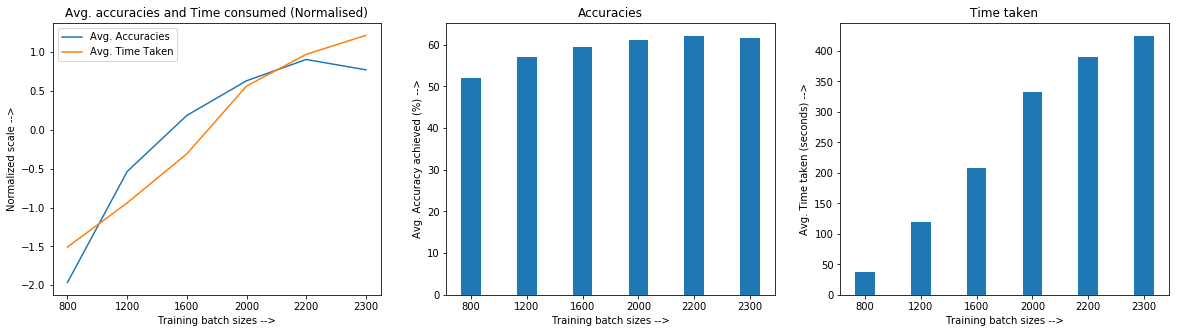

In [0]:
size_list = [800, 1200, 1600, 2000, 2200, 2300]
norm_accuracies = (accuracies-accuracies.mean())/accuracies.std()
norm_time_taken = (time_taken-time_taken.mean())/time_taken.std()

f1 = plt.figure(figsize=(20,5))

f1.add_subplot(1,3,1)
plt.title("Avg. accuracies and Time consumed (Normalised)")
plt.plot(norm_accuracies, label="Avg. Accuracies")
plt.plot(norm_time_taken, label="Avg. Time Taken")
plt.xticks(np.arange(6), size_list)
plt.xlabel("Training batch sizes -->")
plt.ylabel("Normalized scale -->")
plt.legend()


f1.add_subplot(1,3,2)
plt.title("Accuracies")
plt.bar(np.arange(6), accuracies, 0.35, label="accuracies")
plt.xticks(np.arange(6), size_list)
plt.xlabel("Training batch sizes -->")
plt.ylabel("Avg. Accuracy achieved (%) -->")

f1.add_subplot(1,3,3)
plt.title("Time taken")
plt.bar(np.arange(6), time_taken, 0.35, label="time taken")
plt.xticks(np.arange(6), size_list)
plt.xlabel("Training batch sizes -->")
plt.ylabel("Avg. Time taken (seconds) -->")

plt.show(block=True)

### OBSERVATION AND EXPLANATION :
With varying training set size, it can be observed that:-
1. **Avg. Time taken increases almost linearly** with uniform increase in training data set. This increase is evident as model has to perform more computations leading to increase in time taken.
2. **Avg. Accuracy increases non-uniformaly upto a certain point.** Initial growth rate in model performance (accuracy) is higher than subsequent increase in training data set size. This may be due to convergence of accuracy and hence model's ability to improve after certain ponit.
3. **A gradual drop in accuracy after 2200 train data set size.** This may happen maybe due to overfitting of model or poor random sampling of train data set that led to drop in testing accuracy.

## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 40-50%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 50-70%). <br>

# Final report
For the sequences of experiments performed on given dataset:-
1. ### Classifying data with Tiny images representation and nearest neighbor classifier
Entire training and test data was normalised using standard scaling. i.e. subtracting each image with it's mean and dividing the result with standard deviation.
The resulting images were resized to 16x16 for Tiny representation and trained in K-neighbour classifier. 
</br>
<b>Model accuracy = 22.75%</b></br>
<b>Total time taken = 0.5134134292602539sec</b>

2. ### Classifying data with Bag of SIFT representation and nearest neighbor - classifier
Here, SIFT features were extracted using ```cv2.xfeatures2d.SIFT_create()``` as SIFT object for every test and train images. A separate variable ```vocab``` was used for clustering which was different from ```train_data``` sift features as it contained each SIFT feature as an individual entity. Test and Train data's SIFT features were grouped with their respective images (which were densly packed keypoints with step-size = 10). KMeans clustering algorithm was used to create bag of words by clustering each SIFT feature from ```vocab```. This generated "Bag of words" (clusters) were used to create histograms for each image by grouping SIFT features of each image. Resulting features (histograms) were used for training and testing the given data. <u>Since calculating SIFT features of train and test data with KMeans clustering was time consuming, these variables were dumped in a pickle file for directly loading them and save processing time.</u>
<br>
<b>Model accuracy = 58.75%</b></br>
<b>Total time taken = 0.12822437286376953sec sec</b>

3. ### Classifying Bag of SIFT representation and linear SVM classifier (OneVsRest classifier)
With previously calculated "Bag of Words", OneVsRest classifier over SVM was trained using different values of regularization parameter. It was observed that keeping value of regularization parameter ```C=0.001``` resulted in highest accuracy and relatively lesser time. Moreover **with increase in value of regularization parameter ```C```, time consumption of model Increased.**
Later, this model was tested with varying size of trian data set and nearly uniform increase in total time consumption with gradual increase in accuracy was observed. (Discussed with plots in problem 3.b)
<br/>
<b>Model accuracy = 67.75%%</b></br>
<b>Total time taken = 1.3658602237701416</b> <br><br/>
(Note:- for evaluation on new test data (test2), train and test features were combined in-order to increase the total data size and achieve more accuracy)

## Comparision (resp. PLOTS DRAWN AFTER BELOW)
* On the basis of **Accuracy**:- <br/>
Bag of words with OneVsRest_SVM classifier > Bag of words with K-Neighbour classifier > Tiny-image classification using K-Neighbour classifier

* On the basis of **Time taken**:- <br/>
Bag of words with K-Neighbour classifier > Tiny-image classification using K-Neighbour classifier > Bag of words with OneVsRest_SVM classifier

## Observing Confusion matrix
* For classification using Tiny-image representations, we can observe that **model mostly classified images as either COAST or HIGHWAY** with mostly correct classifications for few classes such as COAST, HIGHWAY, STREET FLOWER and SUBURB.
<br/> <br/>
* For classification using K-Neighbour classifier over Bag-of-words using SIFT features, **predictions have significantly improved than earlier.** However it is interesting to note that **INDUSTRY** class is least accurately predicted compared to other classes.
<br/> <br/>
* For classification using OneVsRest classifier over Bag-of-words using SIFT features, **Prediction were more accurate than earlier.** However **INDUSTRY** class was still poorly detected by the model.


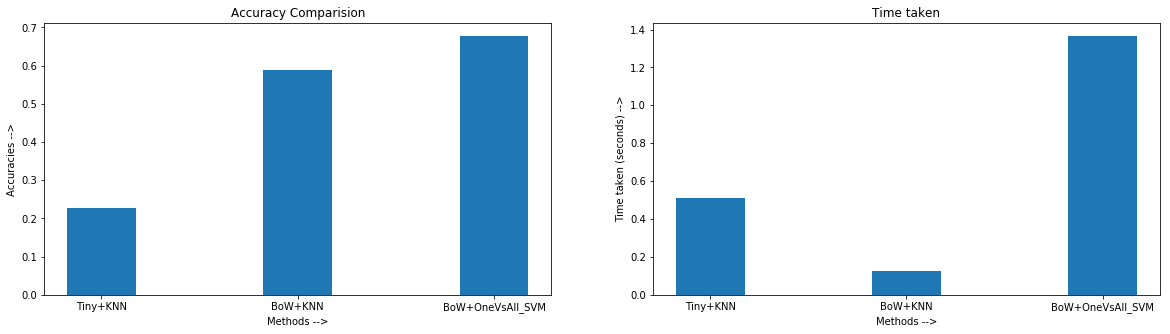

In [0]:
# Comparitive performance
f1 = plt.figure(figsize=(20,5))
methods = ["Tiny+KNN", "BoW+KNN", "BoW+OneVsAll_SVM"]
accuracies_list = [accuracy1, accuracy2, accuracy3]
time_taken_list = [time1, time2, time3]
f1.add_subplot(1,2,1)
plt.title("Accuracy Comparision")
plt.bar(np.arange(3), accuracies_list, 0.35, label="accuracies")
plt.xticks(np.arange(3), methods)
plt.xlabel("Methods -->")
plt.ylabel("Accuracies -->")

f1.add_subplot(1,2,2)
plt.title("Time taken")
plt.bar(np.arange(3), time_taken_list, 0.35, label="time_taken")
plt.xticks(np.arange(3), methods)
plt.xlabel("Methods -->")
plt.ylabel("Time taken (seconds) -->")

plt.show()


Tiny Image representation and nearest neighbor classifier
Time consumed = 0.51 sec and accuracy achieved = 22.75%



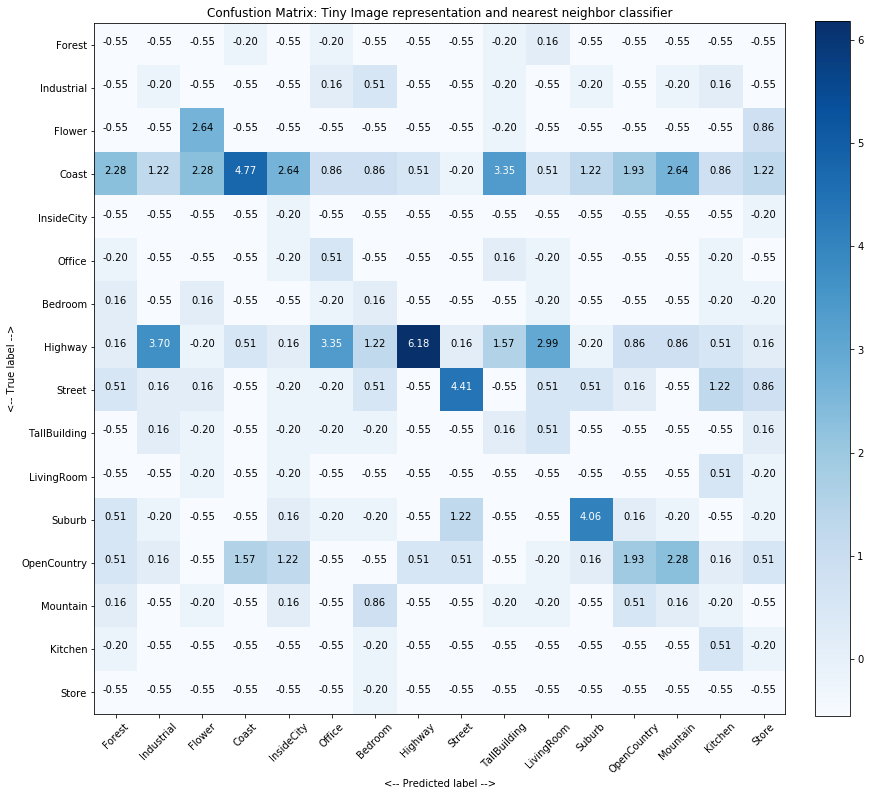


Bag of SIFT representation and nearest neighbor - classifier
Time consumed = 0.13 sec and accuracy achieved = 58.75%



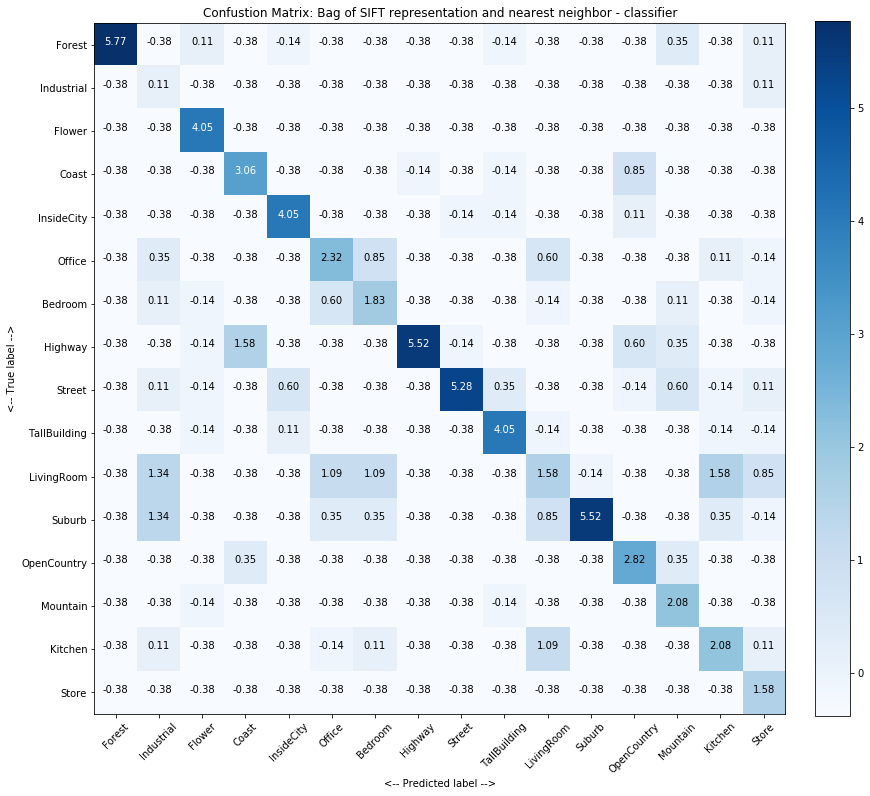


Bag of SIFT representation and OneVsAll SVMs
Time consumed = 1.37 sec and accuracy achieved = 67.75%



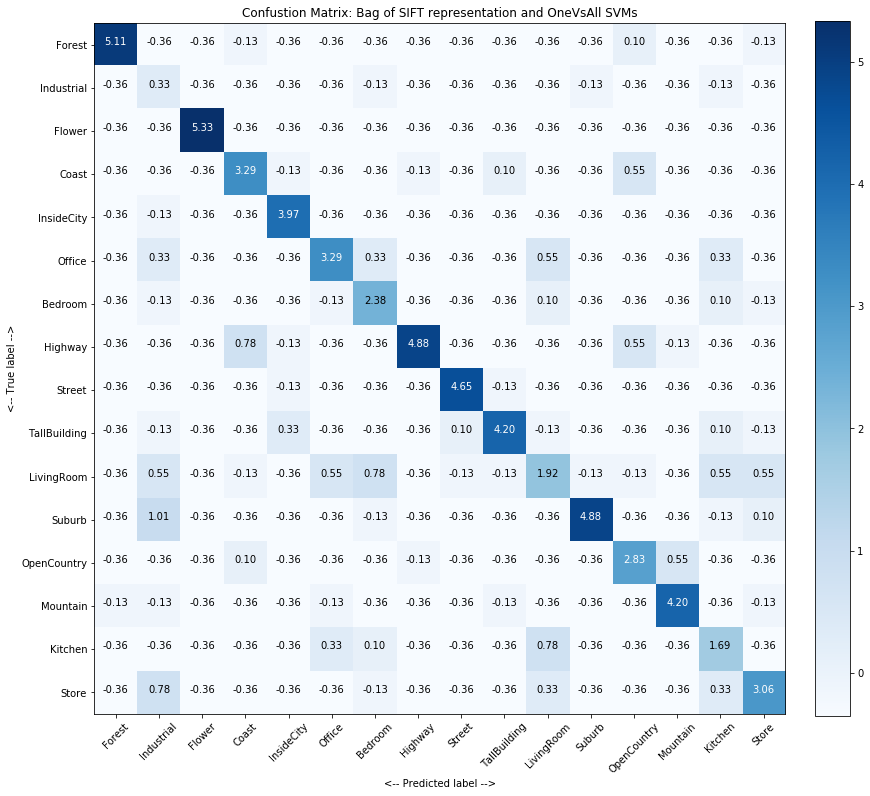

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
      cm = (cm-cm.mean())/cm.std()

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.title(title)
    plt.colorbar(im,fraction=0.046, pad=0.04)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('<-- True label -->')
    plt.xlabel('<-- Predicted label -->')

c_names = [name[13:] for name in glob.glob('./data/train/*')]

# First combination:
title = "Tiny Image representation and nearest neighbor classifier"
print("\n" + title + "\nTime consumed = {:.2f} sec and accuracy achieved = {}%\n".format(time1, accuracy1*100))
# Confusion matrix
cm1 = confusion_matrix(pred1, label1)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, title="Confustion Matrix: " + title, normalize=True)
plt.show()

# Second combination:
title = "Bag of SIFT representation and nearest neighbor - classifier"
print("\n" + title + "\nTime consumed = {:.2f} sec and accuracy achieved = {}%\n".format(time2, accuracy2*100))
# Confusion matrix
cm2 = confusion_matrix(pred2, label2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, title="Confustion Matrix: " + title, normalize=True)
plt.show()

# Third combination:
title = "Bag of SIFT representation and OneVsAll SVMs"
print("\n" + title + "\nTime consumed = {:.2f} sec and accuracy achieved = {}%\n".format(time3, accuracy3*100))
# Confusion matrix
cm3 = confusion_matrix(pred3, label3)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, title="Confustion Matrix: " + title, normalize=True)
plt.show()

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw3' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
        |---Surname_Givenname_SBUID_Pred*.txt
```

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw3.zip" for homework3 in this structure:
```
Jordan_Michael_111134567_hw3
        |---Jordan_Michael_111134567_hw3.ipynb
        |---Jordan_Michael_111134567_hw3.pdf
        |---Jordan_Michael_111134567_Pred.txt
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

